# Image segmentaion with masked facies

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from numbers import Integral
from random import uniform
from PIL import Image as pil_image
import fastai
from fastai.vision import *
from fastai.vision import Image
from fastai.vision.transform import _minus_epsilon
from fastai.vision.data import SegmentationProcessor
from mask_functions import *
from collections import defaultdict
import cv2
from IPython.display import display 

In [3]:
fastai.__version__

'1.0.60.dev0'

In [4]:
torch.cuda.set_device(0)

In [5]:
SUBSET_DATA=False
SUBSET_LEN=100

In [6]:
tgt_height = 256
data_dir = Path('data')
train_images = data_dir/'train_images'
test_img = train_images/'mask_fill/test'


train_path = train_images/'mask_fill/train'
train_mask = train_path/'masks'
train_img = train_path/'images'

cropped_base=train_images/'cropped'
cropped_base.mkdir(exist_ok=True) 
cropped_base = cropped_base/'mask_fill'
cropped_base.mkdir(exist_ok=True) 
cropped_train = cropped_base/'train'
cropped_train.mkdir(exist_ok=True) 

cropped_train_mask = cropped_train/'masks'
cropped_train_mask.mkdir(exist_ok=True) 

cropped_train_img = cropped_train/'images'
cropped_train_img.mkdir(exist_ok=True) 

cropped_test = cropped_base/'test'
cropped_test.mkdir(exist_ok=True) 
cropped_test_img=cropped_test/'cropped'
cropped_test_img.mkdir(exist_ok=True) 


In [7]:
filename = 'data/CAX_LogFacies_Train_File.csv'

#### all data

In [8]:
training_data = pd.read_csv(filename)
training_data.head()
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'
wells=training_data['well_file'].unique()
all_wells_df=pd.DataFrame(wells)
all_wells_df.head()
    
df_val = all_wells_df.sample(frac=0.2)
idx=df_val.index
df_trn=all_wells_df[~all_wells_df.index.isin(idx)]
assert len(df_val)+len(df_trn)==len(all_wells_df)
df_val.to_csv(train_path/'val_20pct.csv', index=False, header=False)

In [9]:
df_val.head()

,0
3492,well_3492.png
2515,well_2515.png
2928,well_2928.png
143,well_143.png
15,well_15.png


#### Subset

In [10]:
df_val = pd.read_csv(train_images/'mask_fill/train/val_20pct.csv', names=["well_id"])
ids=range(0,SUBSET_LEN)
well_names=[]
for i in ids:
    well_names.append('well_'+str(i)+'.png')
#df_sub_val=df_val.loc[df_val['well_id'].isin(well_names)]
#df_sub_val.to_csv(train_sub_path/'val_sub_20pct.csv', index=False, header=False)

### Data

In [11]:
train_img_names = get_image_files(train_img)
len(train_img_names)

4000

In [12]:
train_img_names[:3]

[PosixPath('data/train_images/mask_fill/train/images/well_2640.png'),
 PosixPath('data/train_images/mask_fill/train/images/well_2552.png'),
 PosixPath('data/train_images/mask_fill/train/images/well_1321.png')]

In [13]:
train_mask_names = get_image_files(train_mask)
train_mask_names[:3]

[PosixPath('data/train_images/mask_fill/train/masks/well_2640.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_2552.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_1321.png')]

In [14]:
test_img_names = get_image_files(test_img)
test_img_names[:3]

[PosixPath('data/train_images/mask_fill/test/well_6076_GR.png'),
 PosixPath('data/train_images/mask_fill/test/well_5383_GR.png'),
 PosixPath('data/train_images/mask_fill/test/well_5135_GR.png')]

In [15]:
c_train_img_names = get_image_files(cropped_train_img)
c_train_mask_names = get_image_files(cropped_train_mask)
c_test_img_names = get_image_files(cropped_test_img)

#### Resize all images to square

In [16]:
def resize_to(f, outpath):
    '''using open CV to resize as this allows exact dims to be used'''
    pil_im=pil_image.open(f)
    img=np.array(pil_im)
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    resized = cv2.resize(img, size, interpolation = cv2.INTER_LANCZOS4) 
    outimg = pil_image.fromarray(resized, "RGB" )
    out_file=outpath/f'{f.name}'
    outimg.save(out_file)
    outimg.close()

In [17]:
def resize_all(size, fnames, mnames):
    pma=path_lbl/f'{size[0]}'
    os.makedirs(pma, exist_ok=True)
    pim=path_img/f'{size[0]}'
    os.makedirs(pim, exist_ok=True)
    for f in fnames:
        resize_to(f, pim)
    for f in mnames:
        resize_to(f, pma)

In [18]:
#resize_all((tgt_height,tgt_height), fnames, lbl_names)

In [19]:
def resize_masks():
    img = img.resize((new_width, new_height), Image.ANTIALIAS)

#### Image Crop

In [20]:
def crop_n(img, crop_start):
    #(left, top, right, bottom)
    img_width, img_height = img.size
    if crop_start<4:
        cs = crop_start*(img_height)
    else:
        cs = int(((crop_start-4)+0.5)*(img_height))
    #print(f'w {img_width}, h {img_height}, crop_start: {crop_start}, cs: {cs}')
    crop=((cs),0,(cs + img_height), img_height)
    #print(crop)
    return img.crop(crop)

In [21]:
def crop_n_save(im, out_pth):
    x=pil_image.open(im)
    im_name=im.name.split('.png')[0]
    for n in range(7):
        c=crop_n(x, n)
        c.save(out_pth/f'{im_name}_crop_{n}.png')

In [22]:
for im in train_img_names:
    crop_n_save(im, cropped_train_img)
    
for mask in train_mask_names:
    crop_n_save(mask, cropped_train_mask)
    


In [23]:
for im in test_img_names:
    crop_n_save(im, cropped_test_img)

### Data QC

In [24]:
ims = [open_image(cropped_train_img/f'well_{i}_crop_5.png') for i in range(6)]
im_masks = [open_image(cropped_train_mask/f'well_{i}_crop_5.png') for i in range(6)]

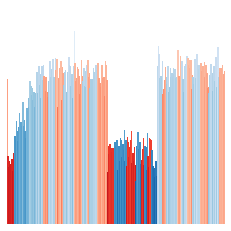

In [25]:
ims[0].show(figsize=(18,4))

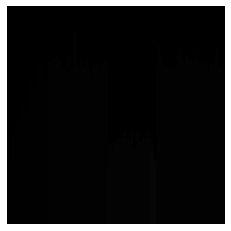

In [26]:
im_masks[0].show(figsize=(18,4))

In [27]:
imt = [open_image(cropped_test_img/f'well_{i}_crop_5.png') for i in range(5000, 5005)]
imt[0].show(figsize=(18,4))

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ssd_1TB/Data/comps/crowdai/gamma_log_facies/train_images/cropped/mask_fill/test/cropped/well_5000_crop_5.png'